In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [5]:
path_to_image_buoy1 = '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy1/train/buoy156.png'
path_to_image_buoy2 = '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/train/buoy108.png'
path_to_image_buoy3 = '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy3/train/buoy28.png'
img1 = cv2.imread(path_to_image_buoy1)
img2 = cv2.imread(path_to_image_buoy2)
img3 = cv2.imread(path_to_image_buoy3)
cv2.imshow('img1',img1)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

mu:9.765625sigma:19.870275
mu:9.765625sigma:26.297571
mu:9.765625sigma:10.711766


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


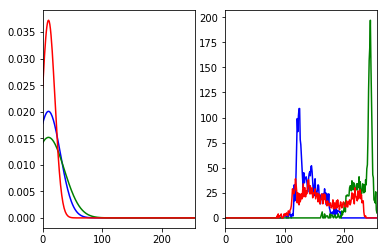

In [6]:
# Compute the average colour histogram for each of the RGB Colour channels
from scipy.stats import norm

def fit_gaussian(image):
    
    color = ('b' , 'g' , 'r') # The number of color channels
    
    for i, col in enumerate(color):
        
        # Calculate the histogram for the Red Green and Blue color channel
        # If input is grayscale the channels = [0] but for color image the channels can be [0], [1], [2]
        histr = cv2.calcHist([image],[i],None,[256],[0,256])

        (mu , sigma) = norm.fit(histr) # Maximum likelihood estimate
        bins = np.linspace(0,255,256)
        print("mu:" + str(mu) + "sigma:" + str(sigma))
        plt.subplot(1,2,1)
        plt.plot(bins, norm.pdf(bins,mu,(sigma)),color=col); plt.xlim([0,256])
        plt.subplot(1,2,2)
        plt.plot(histr,color = col); plt.xlim([0,256])
    plt.show()
    
fit_gaussian(img3)

In [84]:
# initialise step of em algorithm
def initialise_step(n, d, k):
    weights_gaussian = np.zeros(k)
    mean_gaussian = np.zeros((k, d))
    covariance_matrix_gaussian = np.zeros((k, d, d))
    probability_values = np.zeros((n, k))
    
    # randomly assign probability values
    for index in range(0, n):
        probability_values[index][np.random.randint(0, k)] = 1
        
    # return the arrays
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)


# gaussian estimation for expectation step
def gaussian_estimation(data_point, mean, covariance, dimension):
    determinant_covariance = np.linalg.det(covariance)
    determinant_covariance_root = np.sqrt(determinant_covariance)
    covariance_inverse = np.linalg.inv(covariance)
    gaussian_pi_coeff = 1.0 / np.power((2 * np.pi), (dimension / 2))
    data_mean_diff = (data_point - mean)
    data_mean_diff_transpose = data_mean_diff.T     
    return (gaussian_pi_coeff) * (determinant_covariance_root) * np.exp(-0.5 * np.matmul(np.matmul(data_mean_diff, covariance_inverse), data_mean_diff_transpose))


# e-step of the algorithm
# reference: https://towardsdatascience.com/an-intuitive-guide-to-expected-maximation-em-algorithm-e1eb93648ce9
def expectation_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values):
    probabilities = []
    for j in range(0, n):
        probability_x = 0.0
        for i in range(0, k):
            probability_x = probability_x + gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i] * weights_gaussian[i], d)
        probability_x_temp=[]    
        for i in range(k):
            val = gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i] * weights_gaussian[i], d) / probability_x
            probability_x_temp.append(val)
        probabilities.append(probability_x_temp)
    return np.array(probabilities)


# update weights, maximization step
def update_weights(probabilities, k):
    probabilities = np.array(probabilities)
    updated_weights = []
    for i in range(0, k):
        updated_weights.append(np.sum(probabilities[:, i]))
    updated_weights = np.array(updated_weights)
    return updated_weights / np.sum(updated_weights)


# update mean, maximization step
def update_mean(data, probabilities, k):
    probabilities = np.array(probabilities)
    data = np.array(data)
    updated_weights = []
    updated_mean = np.matmul(probabilities.T, data)
    for i in range(0, k):
        updated_weights.append(np.sum(probabilities[:, i]))
        updated_mean[i] = updated_mean[i] / updated_weights[i]
    return updated_mean

# update covariance, maximization step
def update_covariance(data, probabilities, mean_gaussian, k):
    return data

# m-step of the algorithm
# reference: https://towardsdatascience.com/an-intuitive-guide-to-expected-maximation-em-algorithm-e1eb93648ce9
def maximization_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values):
    u_weights = update_weights(probability_values, k)
    u_mean_gaussian = update_mean(data, probabilities, k)
    u_covariance_matrix_gaussian = update_covariance(data, probabilities, mean_gaussian, k)
    return (u_weights, u_mean_gaussian, u_covariance_matrix_gaussian)

# run e-m algorithm
def run_expectation_maximization_algorithm(n, d, k, iterations, data):
    # initialise step
    (weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values) = initialise_step(n, d, k)
    
    # run for fixed iterations
    for i in range(0, iterations):
    
        # m-step
        (weights_gaussian, mean_gaussian, covariance_matrix_gaussian) = maximization_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)
    
        # e-step
        probability_values = expectation_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)
    
    # return answer
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian)

In [30]:
w, m, c, p = initialise_step(2, 2, 2)

In [82]:
s = np.array([[1, 2], [3, 3]])
print(np.sum(s[:, 0]))

4


In [81]:
print(s)

[[1 2]
 [3 3]]
